(218, 636, 20)


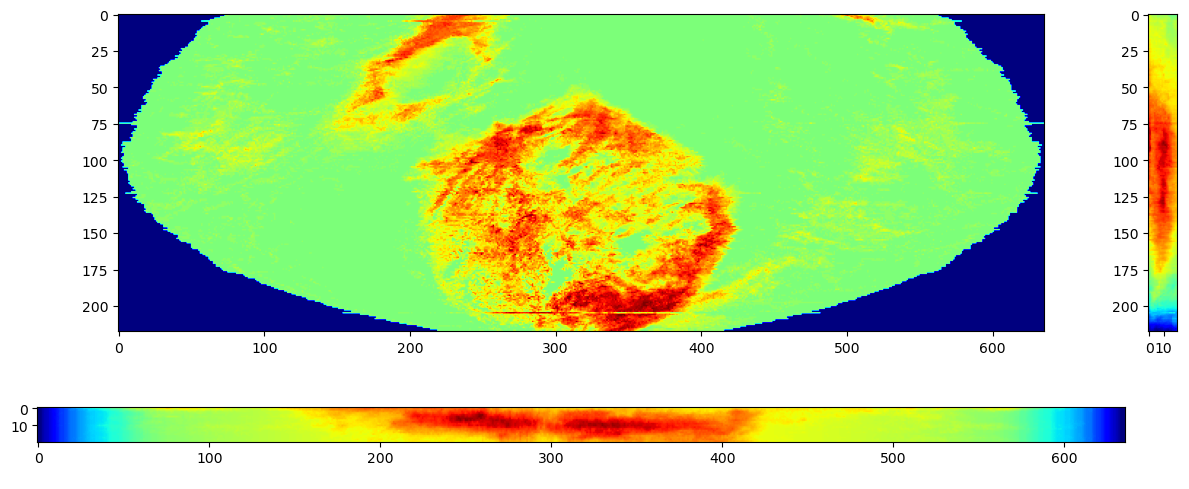

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# path = Path("/Users/arstanbek/Projects/fibrosis/BiTis/data/3D")
# path = Path("/home/arstan/Projects/Fibrosis/BiTis/data/3D")
path = Path("/Users/arstanbek/Projects/fibrosis/FibrosisSimulation/data")
hearts_list = ["Zep1", "Zep3", "Zep4",
               "Zep6", "Zep7", "Zep8",
               "Zep9", "Zep10", "Zep11"]

heart = hearts_list[0]
slab_or = np.load(path.joinpath(heart, "slab.npy")).astype(np.float32)

print(slab_or.shape)


fig, axs = plt.subplots(2, 2, figsize=(12, 5),
                        width_ratios=[1, slab_or.shape[2]/slab_or.shape[1]],
                        height_ratios=[1, slab_or.shape[0]/slab_or.shape[1]])

axs[0, 0].imshow(slab_or.sum(axis=2), cmap="jet")
axs[0, 1].imshow(slab_or.sum(axis=1), cmap="jet")
axs[1, 0].imshow(slab_or.sum(axis=0).T, cmap="jet")
axs[1, 1].axis("off")
plt.tight_layout()
plt.show()



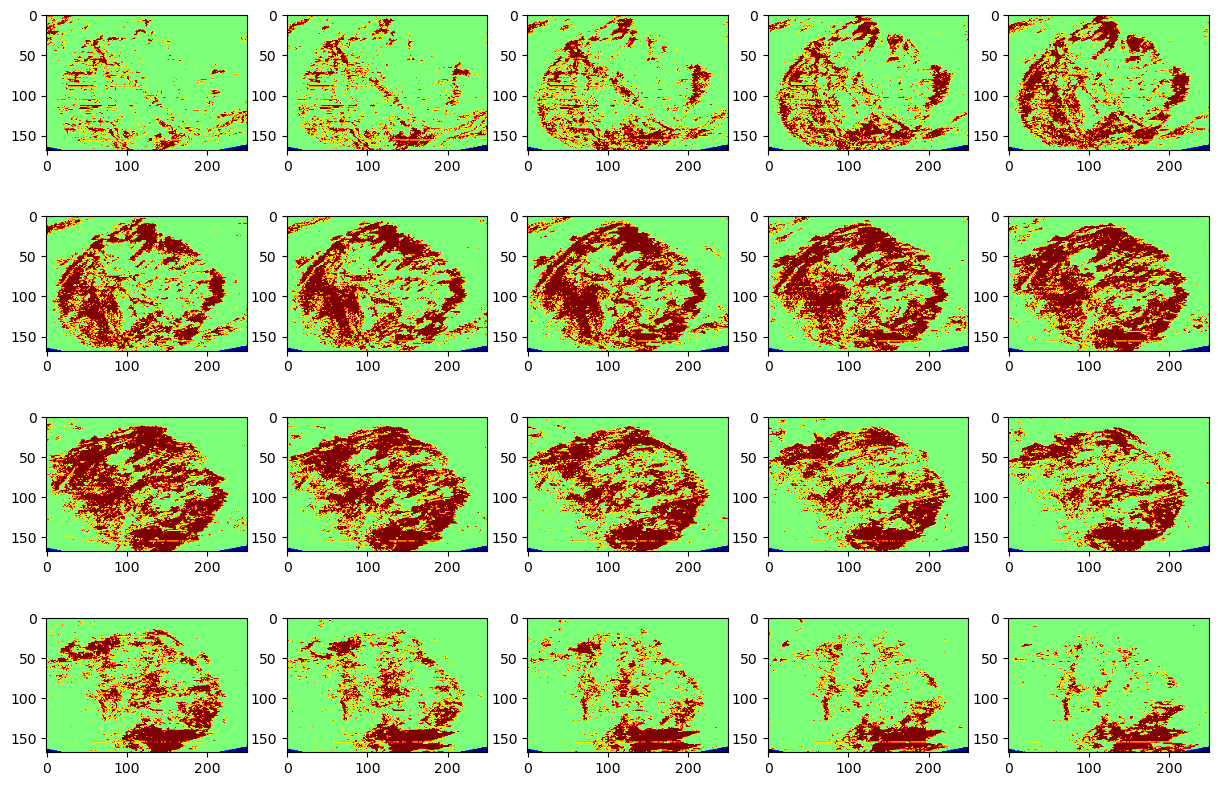

In [2]:
i_min = 50
i_max = min(300, slab_or.shape[0])
j_min = 200
j_max = min(450, slab_or.shape[1])
k_min = 0
k_max = slab_or.shape[2]

slab = slab_or[i_min:i_max, j_min:j_max, k_min:k_max]

fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(15, 10))
for i in range(20):
    axs.flat[i].imshow(slab[..., i], cmap="jet")
plt.show()

[(168, 250, 20), (84, 125, 10), (42, 63, 5)]


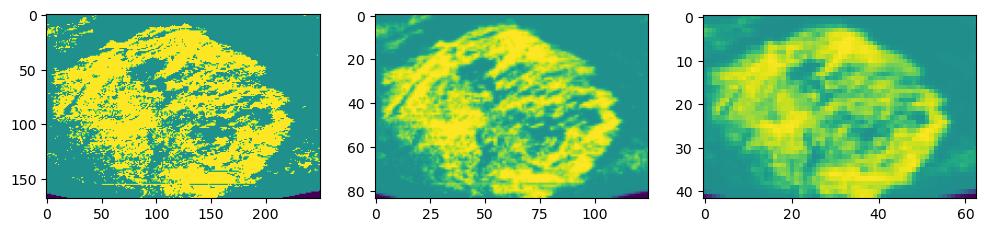

In [3]:
import numpy as np
from skimage.transform import pyramid_gaussian

# img = slab[i_min:i_max, j_min:j_max, 8]
pyramid = tuple(pyramid_gaussian(slab, max_layer=2, downscale=2,
                                 preserve_range=True))

print([p.shape for p in pyramid])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
axs[0].imshow(pyramid[0][:, :, 9])
axs[1].imshow(pyramid[1][:, :, 4])
axs[2].imshow(pyramid[2][:, :, 2])
plt.show()

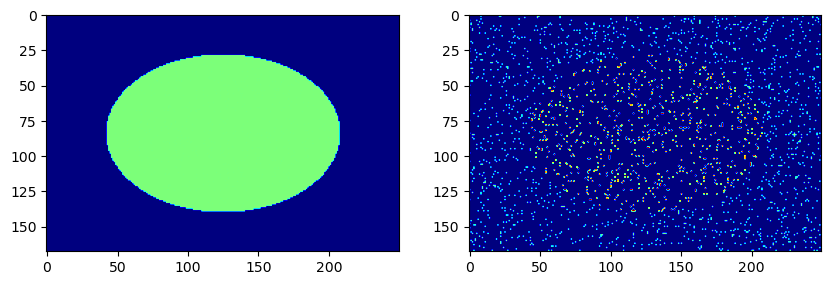

In [4]:

im = np.zeros_like(slab[:, :, slab.shape[2]//2]).astype(bool)
simulation_image = np.zeros_like(im, dtype=int)

# add circle to the image
from skimage import draw
rr, cc = draw.ellipse(im.shape[0]//2, im.shape[1]//2,
                      im.shape[0]//3, im.shape[1]//3)
im[rr, cc] = 1

mask = np.random.rand(*im.shape) < 0.05
simulation_image[(im == 0) & mask] = 1
simulation_image[(im > 0) & mask] = 2

%matplotlib inline
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(im, cmap="jet", vmin=0, vmax=2)
axs[1].imshow(simulation_image, cmap="jet", vmin=0, vmax=2)
plt.show()

100%|██████████| 41168/41168 [00:17<00:00, 2334.22it/s]


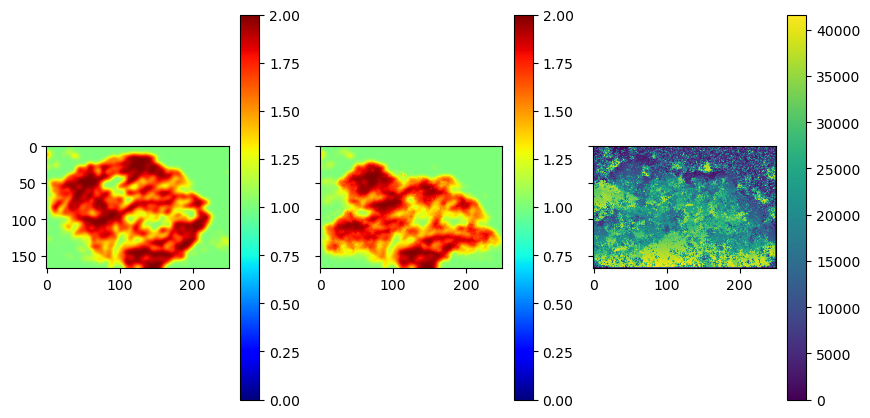

In [22]:
import bitis as bt
from scipy import ndimage


training_image = slab[:, :, slab.shape[2]//2]
training_image[training_image == 0] = 1
training_image = ndimage.gaussian_filter(training_image, 3)

max_known_pixels = 30
max_template_size = 100
min_template_size = 3
num_of_candidates = 5
min_known_pixels = 1

simulation_tex = training_image.copy()
simulation_tex[1:-1, 1:-1] = 0
# mask = np.random.random(training_image.shape) < 0.2
# mask[1:-1, 1:-1] = 0
# simulation_tex[mask] = 1
# simulation_tex[0, :] = 1
# simulation_tex[-1, :] = 1
# simulation_tex[:, 0] = 1
# simulation_tex[:, -1] = 1

simulation = bt.Simulation()
simulation.path_builder = bt.RandomSimulationPathBuilder(simulation_tex)
simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
simulation.template_matching = bt.ContinuousVariableMatching(training_image,
                                                             num_of_candidates,
                                                             min_known_pixels)
simulated_tex = simulation.run()
joint_simulated_image = simulated_tex.copy()
joint_training_image = training_image.copy()

fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.colorbar(ax[0].imshow(joint_training_image, vmin=0, vmax=2, cmap="jet"))
fig.colorbar(ax[1].imshow(joint_simulated_image, vmin=0, vmax=2, cmap="jet"))
fig.colorbar(ax[2].imshow(simulation._index_map, cmap="viridis"))
plt.show()

100%|██████████| 42000/42000 [00:14<00:00, 2915.11it/s]


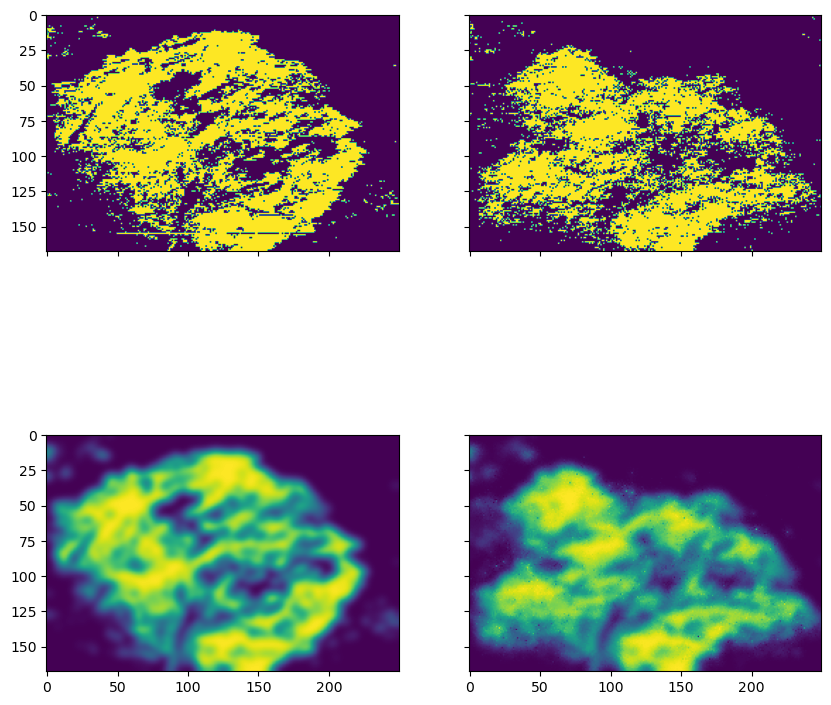

In [23]:
import bitis as bt


training_image = slab[:, :, slab.shape[2]//2].copy()

max_known_pixels = 30
max_template_size = 50
min_template_size = 3
num_of_candidates = 5
min_known_pixels = 1

simulation_tex = np.zeros_like(training_image)
multi_var_simulation = bt.Simulation()
multi_var_simulation.path_builder = bt.MultivariateSimulationPathBuilder(simulation_tex)
multi_var_simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
multi_var_simulation.template_matching = bt.MultivariateVariableMatching(training_image,
                                                               joint_training_image,
                                                               joint_simulated_image,
                                                               num_of_candidates,
                                                               min_known_pixels)

simulated_tex = multi_var_simulation.run()

%matplotlib inline

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10),
                       sharex=True, sharey=True)
ax[0, 0].imshow(training_image)
ax[0, 1].imshow(simulated_tex)
ax[1, 0].imshow(joint_training_image)
ax[1, 1].imshow(joint_simulated_image)
plt.show()

In [24]:
sim_slab = np.zeros_like(slab)
sim_slab[:, :, slab.shape[2]//2] = simulated_tex
joint_simulated_image = ndimage.gaussian_filter(simulated_tex, 5)
joint_training_image = ndimage.gaussian_filter(slab[:, :, slab.shape[2]//2], 5)

In [25]:
for i in range(slab.shape[2]//2, 0, -1):
    training_image = slab[:, :, i - 1].copy()
    # joint_training_image = ndimage.gaussian_filter(slab[:, :, i], 5)
    # joint_simulated_image = ndimage.gaussian_filter(sim_slab[:, :, i], 5)

    simulation_tex = np.zeros_like(training_image)

    multi_var_simulation = bt.Simulation()
    multi_var_simulation.path_builder = bt.MultivariateSimulationPathBuilder(simulation_tex)
    multi_var_simulation.template_builder = bt.AdaptiveTemplateBuilder(simulation_tex,
                                                         max_known_pixels,
                                                         max_template_size,
                                                         min_template_size)
    multi_var_simulation.template_matching = bt.MultivariateVariableMatching(training_image,
                                                               joint_training_image,
                                                               joint_simulated_image,
                                                               num_of_candidates,
                                                               min_known_pixels)

    simulated_tex = multi_var_simulation.run()
    sim_slab[:, :, i - 1] = simulated_tex.copy()

100%|██████████| 42000/42000 [00:14<00:00, 2961.83it/s]


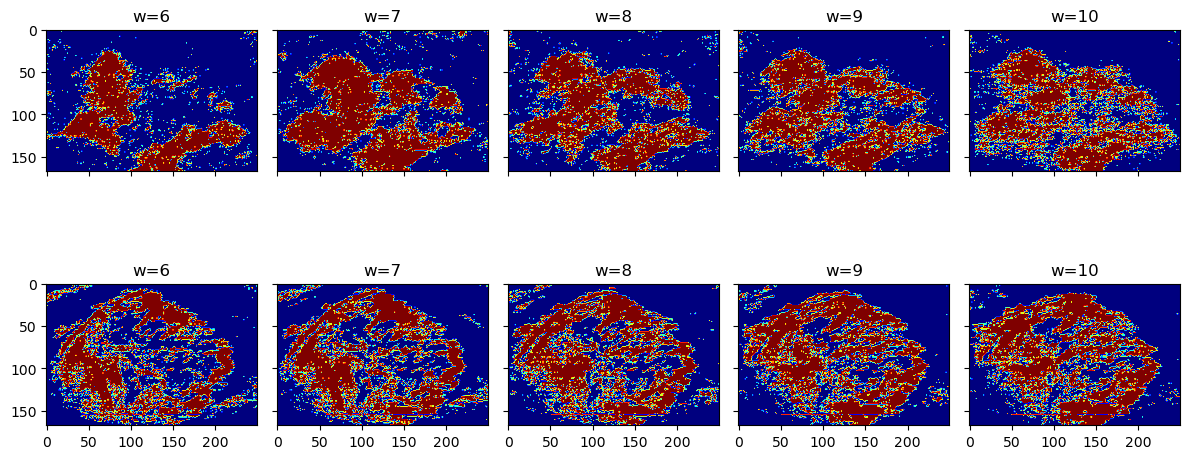

In [27]:
%matplotlib inline

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(12, 6), sharey=True,
                        sharex=True, width_ratios=[1, 1, 1, 1, 1])
# axs[0, 1].imshow(sim_slab[:, :, :sim_slab.shape[2]//2].mean(axis=2), cmap="jet",
#                   vmin=0, vmax=2)
# axs[0, 0].imshow(sim_slab[:, :, :sim_slab.shape[2]//2].mean(axis=0), cmap="jet",
#                   vmin=0, vmax=2)
# axs[1, 1].imshow(slab[:, :, :slab.shape[2]//2].mean(axis=2), cmap="jet",
#                   vmin=0, vmax=2)
# axs[1, 0].imshow(slab[:, :, :slab.shape[2]//2].mean(axis=0), cmap="jet",
#                   vmin=0, vmax=2)
# axs[0, 1].set_title("mean")

for i, idx in enumerate(np.linspace(6, sim_slab.shape[2]//2, 5).astype(int)):
    axs[0, i].imshow(sim_slab[:, :, idx], cmap="jet", vmin=1, vmax=2)
    axs[1, i].imshow(slab[:, :, idx], cmap="jet", vmin=1, vmax=2)
    axs[0, i].set_title(f"w={idx}")
    axs[1, i].set_title(f"w={idx}")
plt.tight_layout()
plt.show()
# fig.savefig("adaptive_sampling_3d.png", dpi=300, bbox_inches='tight')

(165, 350) (165, 350)


100%|██████████| 56826/56826 [00:51<00:00, 1099.91it/s]


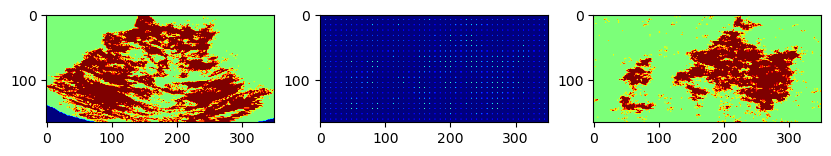

In [91]:
import bitis as bt

texture_ = slab[:, :, slab.shape[2]//2].copy()

precondition_tex = simulation_tex.copy()

print(texture_.shape, simulation_tex.shape)


# simulation_tex = sim_slab.copy()
simulation = bt.AdaptiveSampling(simulation_tex,
                                 texture_,
                                 max_known_pixels=30,
                                 max_template_size=50,
                                 min_template_size=3,
                                 min_distance=0.1,
                                 min_known_pixels=1,
                                 use_tf=True)

simulated_tex = simulation.run(max_iter=None)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(texture_, vmin=0, vmax=2, cmap='jet')
ax[1].imshow(precondition_tex, vmin=0, vmax=2, cmap='jet')
ax[2].imshow(simulated_tex, vmin=0, vmax=2, cmap='jet')
plt.show()

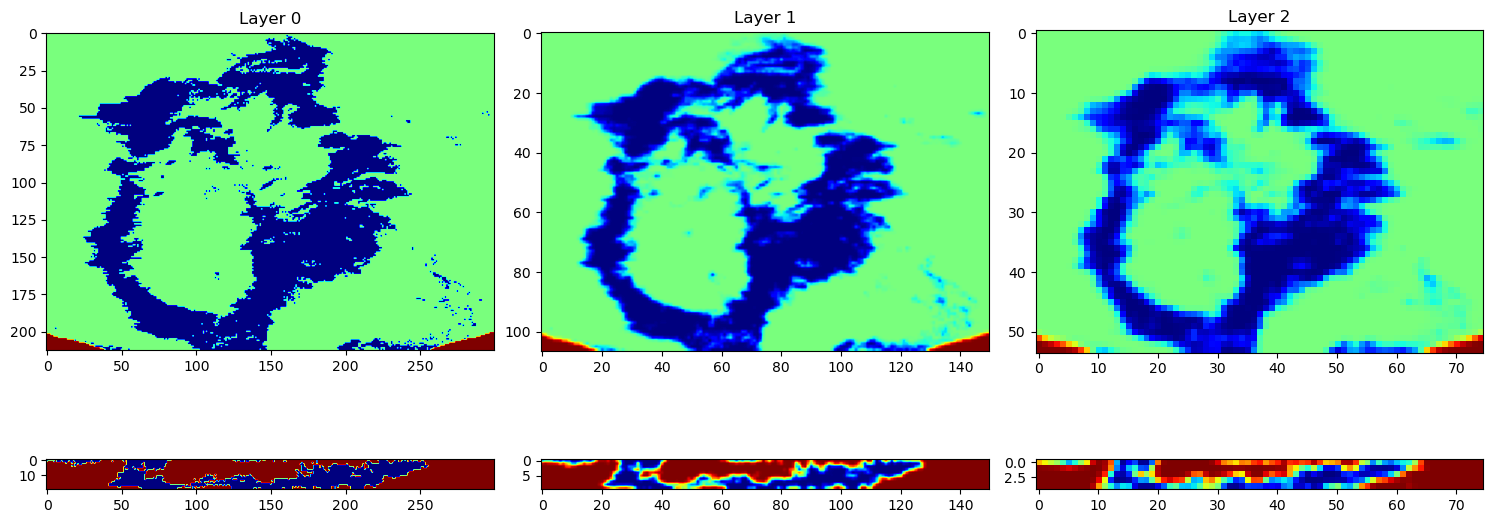

In [8]:

import numpy as np
from skimage.transform import pyramid_gaussian

img = slab[:, :, slab.shape[2]//2]
pyramid = tuple(pyramid_gaussian(slab, max_layer=2, downscale=2,
                                 preserve_range=True))

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 6.8))

for i, p in enumerate(pyramid):
    axs[0, i].imshow(p[:, :, p.shape[2]//2], cmap="jet_r")
    axs[0, i].set_title(f"Layer {i}")

    axs[1, i].imshow(p[p.shape[0]//2, :, :].T , cmap="jet_r")
    axs[1, i].sharex(axs[1, i])
plt.tight_layout()
plt.show()

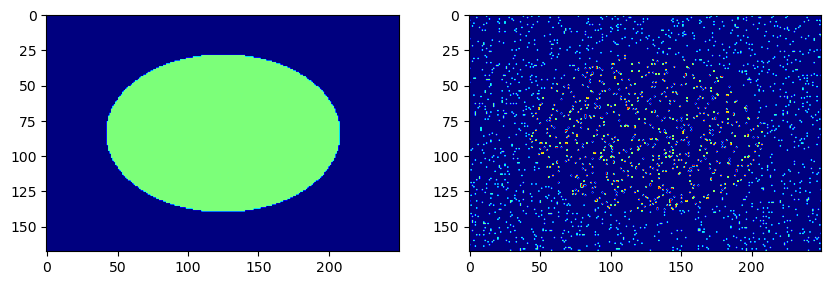

In [15]:

im = np.zeros_like(slab[:, :, slab.shape[2]//2]).astype(bool)
simulation_image = np.zeros_like(im, dtype=int)

# add circle to the image
from skimage import draw
rr, cc = draw.ellipse(im.shape[0]//2, im.shape[1]//2,
                      im.shape[0]//3, im.shape[1]//3)
im[rr, cc] = 1

mask = np.random.rand(*im.shape) < 0.05
simulation_image[(im == 0) & mask] = 1
simulation_image[(im > 0) & mask] = 2

%matplotlib inline
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(im, cmap="jet", vmin=0, vmax=2)
axs[1].imshow(simulation_image, cmap="jet", vmin=0, vmax=2)
plt.show()